https://captum.ai/tutorials/Image_and_Text_Classification_LIME
This tutorial focuses on showing how to use Captum's implementation of Local Interpretable Model-agnostic Explanations (LIME) to understand neural models. 

In [1]:
import torch
import torch.nn.functional as F

from captum.attr import visualization as viz
from captum.attr import Lime, LimeBase
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso

import os
import json

/home/109499@TRI.LAN/Github/fork_EnsembleXAI/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision.models import resnet18
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as T
from captum.attr._core.lime import get_exp_kernel_similarity_function

from PIL import Image
import matplotlib.pyplot as plt

## 1. Load the model and dataset

In [3]:
resnet = resnet18(pretrained=True)
resnet = resnet.eval()

/home/109499@TRI.LAN/Github/fork_EnsembleXAI/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/109499@TRI.LAN/Github/fork_EnsembleXAI/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 ### (train data) ImageNet 1k: mapping of label index and text

In [4]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2024-04-08 11:34:45--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.161.189, 54.231.132.200, 52.217.49.94, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.161.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/home/109499@TRI.LAN/.torch/models/imagenet_class_index.json.3’

imagenet_class_inde 100%[===================>]  34,53K  --.-KB/s    in 0,1s    

2024-04-08 11:34:46 (333 KB/s) - ‘/home/109499@TRI.LAN/.torch/models/imagenet_class_index.json.3’ saved [35363/35363]



In [5]:
labels_path = os.getenv('HOME') + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = {idx: label for idx, [_, label] in json.load(json_data).items()}

### (test data) PASCAL VOC 2012 as the 

In [6]:
voc_ds = VOCSegmentation(
    './VOC',
    year='2012',
    image_set='train',
    download=True, #change to true if not downloaded
    transform=T.Compose([
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )    
    ]),
    target_transform=T.Lambda(
        lambda p: torch.tensor(p.getdata()).view(1, p.size[1], p.size[0])
    )
)

Using downloaded and verified file: ./VOC/VOCtrainval_11-May-2012.tar
Extracting ./VOC/VOCtrainval_11-May-2012.tar to ./VOC


Let's pick one example to see how the image and corresponding mask look like. Here we choose an image with more than one segments besides background so that we can compare each segment's impact on the classification.

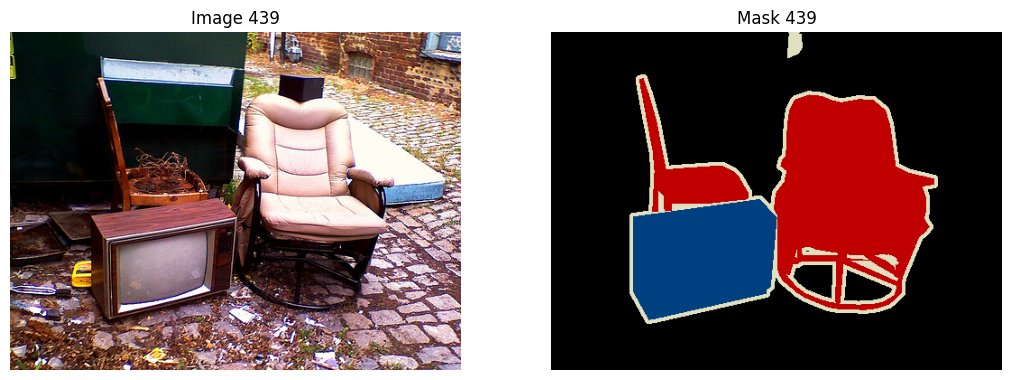

In [7]:
sample_idx = 439

def show_image(ind): 
    fig, ax = plt.subplots(1, 2, figsize=[6.4 * 2, 4.8])
    for i, (name, source) in enumerate(zip(['Image', 'Mask'], [voc_ds.images, voc_ds.masks])):
        ax[i].imshow(Image.open(source[ind]));
        ax[i].set_title(f"{name} {ind}")
        ax[i].axis('off')

show_image(sample_idx)

## 2. Baseline classification

We can check how well our model works with the above example. The original Resnet only gives the logits of labels, so we will add a softmax layer to normalize them into probabilities.

In [8]:
img, seg_mask = voc_ds[sample_idx]  # tensors of shape (channel, hight, width)
print('Img shape:',img.shape)
print('Seg shape:',seg_mask.shape)


outputs = resnet(img.unsqueeze(0))
output_probs = F.softmax(outputs, dim=1).squeeze(0)

Img shape: torch.Size([3, 375, 500])
Seg shape: torch.Size([1, 375, 500])


present the top 5 predicted labels to verify the result.

In [9]:
def print_result(probs, topk=1):
    probs, label_indices = torch.topk(probs, topk)
    probs = probs.tolist()
    label_indices = label_indices.tolist()
    for prob, idx in zip(probs, label_indices):
        label = idx_to_labels[str(idx)]
        print(f'{label} ({idx}):', round(prob, 4))
        
print_result(output_probs, topk=5)

television (851): 0.083
screen (782): 0.0741
monitor (664): 0.0619
laptop (620): 0.0421
ashcan (412): 0.03



## 3. Inspect the model prediction with Lime


### 3.1. Generate masks

In case of an image input, the feature mask is a 2D image of the same size, where each pixel in the mask indicates the feature group it belongs to via an integer value. Pixels of the same value define a group.

This means we can readily use VOC's segmentation masks as feature masks for Captum!

In [10]:
seg_ids = sorted(seg_mask.unique().tolist())
print('Segmentation IDs:', seg_ids)

Segmentation IDs: [0, 9, 20, 255]


However, while segmentaion numbers range from 0 to 255, Captum prefers consecutive group IDs for efficiency. Therefore, we will also include extra steps to convert mask IDs.

In [11]:
# map segment IDs to feature group IDs
feature_mask = seg_mask.clone()
for i, seg_id in enumerate(seg_ids):
    feature_mask[feature_mask == seg_id] = i
    
print('Feature mask:', feature_mask)
print('Feature mask IDs:', feature_mask.unique().tolist())
print('Feature mask shape:',feature_mask.shape)


Feature mask: tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])
Feature mask IDs: [0, 1, 2, 3]
Feature mask shape: torch.Size([1, 375, 500])


### 3.2 Lime: train an interpretrable surrogate model

Similarity function. 
Because Lime aims to explain the local behavior of an example, it will reweight the training samples according to their similarity distances. By default, Captum's Lime uses the exponential kernel on top of the consine distance. We will change to euclidean distance instead which is more popular in vision.

In [12]:
exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)

lr_lime = Lime(
    resnet, 
    interpretable_model=SkLearnLinearRegression(),  # build-in wrapped sklearn Linear Regression
    similarity_func=exp_eucl_distance
)

Next, we will analyze these groups' influence on the most confident prediction television. Every time we call Lime's attribute function, an interpretable model is trained around the given input, so unlike many other Captum's attribution algorithms, it is strongly recommended to only provide a single example as input (tensors with first dimension or batch size = 1).

Setting the `perturbations_per_eval` can batch multiple samples in one forward pass to shorten the process as long as your machine still has capacity

In [13]:
label_idx = output_probs.argmax().unsqueeze(0)

attrs = lr_lime.attribute(
    img.unsqueeze(0),
    target=label_idx,
    feature_mask=feature_mask.unsqueeze(0),
    n_samples=40,
    perturbations_per_eval=16,
    show_progress=True
).squeeze(0)

print('Label idx (should be tv):',label_idx)
print('Attribution range:', attrs.min().item(), 'to', attrs.max().item())

Lime attribution: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


Label idx (should be tv): tensor([851])
Attribution range: -0.3870375156402588 to 2.804391860961914


### 3.3. Visualize the data

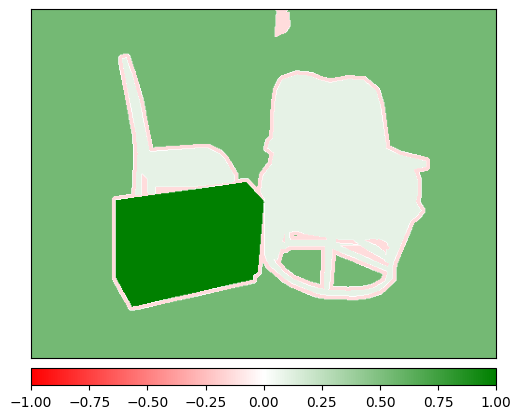

In [14]:
def show_attr(attr_map):
    viz.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),  # adjust shape to height, width, channels 
        method='heat_map',
        sign='all',
        show_colorbar=True
    )
    
show_attr(attrs)

## Now let's do the same, but generating other segments with skimage

In [15]:
from skimage.segmentation import slic

segmenter=slic(image=img.permute(1, 2, 0) ,n_segments=100)
seg_mask=torch.tensor(segmenter)

seg_ids = sorted(seg_mask.unique().tolist())
print('Segmentation IDs:', seg_ids)
print('Segmentation shape:', seg_mask.shape)

Segmentation IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
Segmentation shape: torch.Size([375, 500])


### Visualize the created segments 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


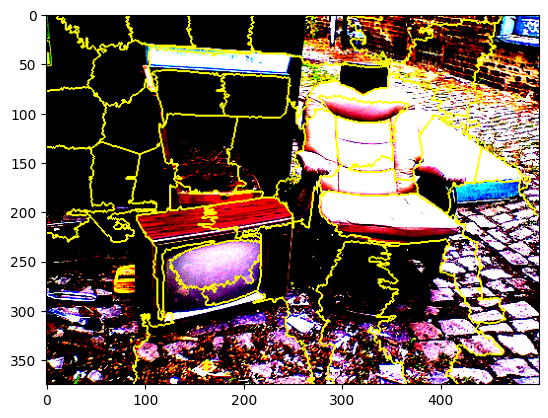

In [16]:
from skimage.segmentation import mark_boundaries
img_wboundaries = mark_boundaries(img.permute(1,2,0).numpy(), segmenter)
plt.imshow(img_wboundaries)

In [17]:
# map segment IDs to feature group IDs
feature_mask = seg_mask.clone()
for i, seg_id in enumerate(seg_ids):
    feature_mask[feature_mask == seg_id] = i
    
print('Feature mask:', feature_mask)
print('Feature mask IDs:', feature_mask.unique().tolist())
print('Feature mask shape:',feature_mask.shape)

Feature mask: tensor([[ 0,  0,  0,  ...,  6,  6,  6],
        [ 0,  0,  0,  ...,  6,  6,  6],
        [ 0,  0,  0,  ...,  6,  6,  6],
        ...,
        [31, 31, 31,  ..., 25, 25, 25],
        [31, 31, 31,  ..., 25, 25, 25],
        [31, 31, 31,  ..., 25, 25, 25]])
Feature mask IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
Feature mask shape: torch.Size([375, 500])


In [18]:
label_idx = output_probs.argmax().unsqueeze(0)

attrs = lr_lime.attribute(
    img.unsqueeze(0),
    target=label_idx,
    feature_mask=feature_mask.unsqueeze(0),
    n_samples=1000,
    perturbations_per_eval=64,
    show_progress=True
).squeeze(0)

print('Label idx (should be tv):',label_idx)
print('Attribution range:', attrs.min().item(), 'to', attrs.max().item())

Lime attribution: 100%|██████████| 16/16 [00:39<00:00,  2.49s/it]

Label idx (should be tv): tensor([851])
Attribution range: -0.2315753996372223 to 1.713115930557251


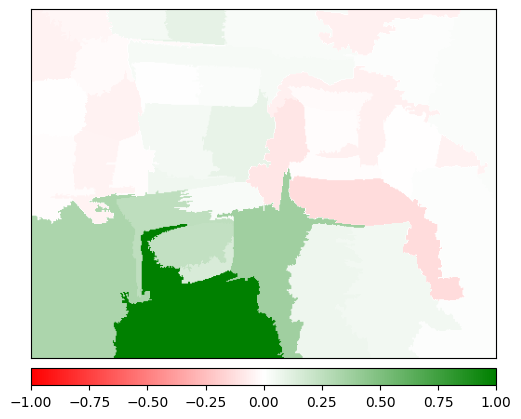

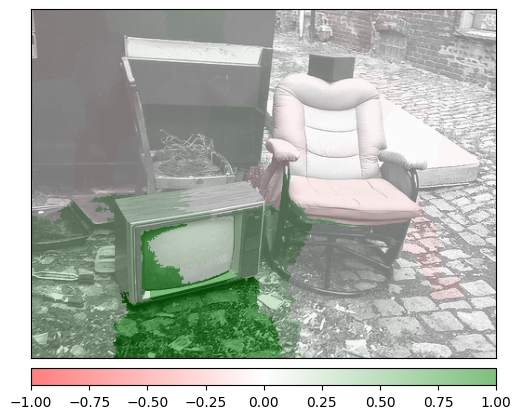

(<Figure size 600x600 with 2 Axes>, <Axes: >)

In [20]:

viz.visualize_image_attr(
    attrs.permute(1, 2, 0).numpy(),  # adjust shape to height, width, channels 
    method='heat_map',
    sign='all',
    show_colorbar=True
)

viz.visualize_image_attr(
    attrs.permute(1, 2, 0).numpy(),  # adjust shape to height, width, channels 
    img.permute(1,2,0).numpy(),
    method='blended_heat_map',
    sign='all',
    show_colorbar=True
)